In [41]:
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel
from datetime import datetime, timedelta
import random
import numpy as np
import matplotlib.pyplot as plt

from DeathPrediction.collect_data import CollectData
from DeathPrediction import death_info
from MongoUtils.mongo_helper import ClientSessionRefresh



In [42]:
def make_dataframes(hives, deaths, hives_that_survived, days_back: int = 60):
    survived_raw_values = {}
    survived_prop_values = {}
    died_raw_values = {}
    died_prop_values = {}
    survived_dataframes = {}
    died_dataframes = {}
    skipped_hives = []
    for hive in hives:
        survived = hive in hives_that_survived
        if hive in deaths:
            end_date = deaths[hive]
        else:
            end_date = datetime(2023, 4, 21)

        start_date = datetime(2022, 4, 10)
        # if hive not in hives_that_survived:
        start_date = max(start_date, end_date - timedelta(days=days_back))

        try:
            df = cd.get_temp_dataframe(hive, start_date=start_date, end_date=end_date)

        except ValueError as e:
            skipped_hives.append(hive)
            print(f"Skipping hive {hive}: {e}")
            continue

        if survived:
            survived_raw_values[hive] = df['TemperatureDifference'].mean()
            survived_prop_values[hive] = df['ProportionalDifference'].mean()
            survived_dataframes[hive] = df

        else:
            died_raw_values[hive] = df['TemperatureDifference'].mean()
            died_prop_values[hive] = df['ProportionalDifference'].mean()
            died_dataframes[hive] = df

    return survived_raw_values, survived_prop_values, died_raw_values, died_prop_values, skipped_hives, survived_dataframes, died_dataframes


In [43]:

def get_info(survived_values, died_values, equal_var: bool = True):
    survived_mean = pd.Series(survived_values).mean()
    survived_median = pd.Series(survived_values).median()
    death_mean = pd.Series(died_values).mean()
    death_median = pd.Series(died_values).median()
    stat, p_value = ttest_ind(list(survived_values.values()), list(died_values.values()), equal_var=equal_var)

    return survived_mean, survived_median, death_mean, death_median, stat, p_value



In [44]:
def analyze_temperature_std(survived_dataframes: dict[str, pd.DataFrame], died_dataframes: dict[str, pd.DataFrame]):
    survived_list = []
    died_list = []
    for hive in survived_dataframes:
        survived_list.extend(survived_dataframes[hive]['TemperatureDifference'])
    for hive in died_dataframes:
        died_list.extend(died_dataframes[hive]['TemperatureDifference'])

    survived_list = [x for x in survived_list if not np.isnan(x)]
    died_list = [x for x in died_list if not np.isnan(x)]
    survived_mean = pd.Series(survived_list).mean()
    survived_median = pd.Series(survived_list).median()
    survived_std = pd.Series(survived_list).std()
    died_mean = pd.Series(died_list).mean()
    died_median = pd.Series(died_list).median()
    died_std = pd.Series(died_list).std()

    sample_size = min(10000, len(survived_list), len(died_list))
    ind_stat, ind_p_value = ttest_ind(
        random.sample(survived_list, sample_size),
        random.sample(died_list, sample_size),
        equal_var=True)
    # paired_stat, paired_p_value = ttest_rel(
    #     random.sample(survived_list, sample_size),
    #     random.sample(died_list, sample_size),
    #     equal_var=True)

    return survived_mean, survived_median, survived_std, died_mean, died_median, died_std, ind_stat, ind_p_value

In [45]:

def plot_std_info(survived_mean, survived_median, survived_std, died_mean, died_median, died_std, stat, p_value):
    # Data for plotting
    categories = ['Survived', 'Died']
    means = [survived_mean, died_mean]
    std_devs = [survived_std, died_std]

    # Create bar chart
    fig, ax = plt.subplots()
    bar_width = 0.4
    index = np.arange(len(categories))

    bars = ax.bar(index, means, bar_width, yerr=std_devs, capsize=5, label='Mean Temperature Difference')

    # Adjust axis limits
    ax.set_ylim(0, max(means) + max(std_devs) + 1)  # Add some padding above the highest bar

    # Add labels and title
    ax.set_xlabel('Group')
    ax.set_ylabel('Mean Temperature Difference')
    ax.set_title('Mean Temperature Difference with Standard Deviation')
    ax.set_xticks(index)
    ax.set_xticklabels(categories)
    ax.legend()

    # Adjust layout to ensure everything fits
    plt.tight_layout()

    # Show plot
    plt.show()


In [46]:

def main(year: int, death_estimate: bool = True, jefferson_hives: bool = False):
    """
    Args:
        year: Year of the summer, so summer 2022-spring 2023 is 2022
        death_estimate: 1 if using the late estimate, 0 if using the early estimate
        jefferson_hives: 1 if using the Jefferson hives, 0 if not using the Jefferson hives

    Returns:

    """
    if year == 2022:
        hives = death_info.get_2022_hives(jefferson_hives=jefferson_hives)
        hives_that_survived = death_info.get_2022_survived()

        if death_estimate:
            deaths = death_info.get_2022_deaths_late(jefferson_hives)
        else:
            deaths = death_info.get_2022_deaths_early(jefferson_hives)
    else:
        raise NotImplementedError("Only 2022 is implemented")

    survived_raw, survived_prop, died_raw, died_prop, skipped_hives, survived_dataframes, died_dataframes = (
        make_dataframes(hives, deaths, hives_that_survived))

    survived_mean, survived_median, death_mean, death_median, stat, p_value = get_info(survived_raw, died_raw, True)
    data = [(survived_mean, survived_median, death_mean, death_median, stat, p_value, skipped_hives)]

    survived_mean, survived_median, death_mean, death_median, stat, p_value = get_info(survived_prop, died_prop, False)
    data.append((survived_mean, survived_median, death_mean, death_median, stat, p_value, skipped_hives))

    return data


In [47]:
cd = CollectData()

trials = pd.DataFrame(
    columns=['Year', 'Data Type', 'Death Estimate', 'Jefferson Hives', 'Survived Mean', 'Died Mean', 'p-value'])
with ClientSessionRefresh(cd.client):
    # for year in [2022]:
    #     for death_estimate in [False, True]:
    #         for jefferson_hives in [False, True]:
    #             results = main(year, death_estimate, jefferson_hives)
    #             for i in range(2):
    #                 survived_mean, survived_median, death_mean, death_median, stat, p_value, skipped_hives = \
    #                 results[i]
    #                 trials = trials._append({
    #                     'Year': year,
    #                     'Death Estimate': "early" if death_estimate else "late",
    #                     'Jefferson Hives': jefferson_hives,
    #                     'Equal Variance': i == 0,
    #                     'Belgium Hives': False,
    #                     'Survived Mean': survived_mean,
    #                     'Survived Median': survived_median,
    #                     'Died Mean': death_mean,
    #                     'Died Median': death_median,
    #                     'stat': stat,
    #                     'p-value': p_value,
    #                     'Skipped Hives': skipped_hives
    #                 },
    #                     ignore_index=True)

    year = 2022
    death_estimate = True
    jefferson_hives = False

    a, b, c, d, e, survived_dfs, died_dfs = make_dataframes(death_info.get_2022_hives(jefferson_hives=jefferson_hives),
                                                            # death_info.get_2022_deaths_late(jefferson_hives),
                                                            death_info.get_2022_deaths_early(jefferson_hives),
                                                            death_info.get_2022_survived(),
                                                            days_back=60)

2024-10-28 15:42:56.996 | INFO     | MongoUtils.mongo_helper:__init__:797 - Initialized Session Refresh Context Manager
2024-10-28 15:42:57.002 | INFO     | MongoUtils.mongo_helper:__init__:726 - Session Thread Initialized.
2024-10-28 15:42:57.003 | INFO     | MongoUtils.mongo_helper:run:732 - Running Session...
2024-10-28 15:42:57.005 | INFO     | MongoUtils.mongo_helper:__enter__:806 - Client Session Thread Started. Refresh Rate: 5 minutes


Skipping hive AppMAIS4L: No records found in HiveWeather or HiveWeather2 collections for the given criteria.


2024-10-28 15:43:32.696 | INFO     | MongoUtils.mongo_helper:exit_loop:741 - Session Thread Terminating...
2024-10-28 15:43:32.737 | INFO     | MongoUtils.mongo_helper:_keep_session_alive:769 - Session Ended
2024-10-28 15:43:32.738 | INFO     | MongoUtils.mongo_helper:__exit__:818 - Client Session Context Manager Exited.


In [48]:
s_mean, s_med, s_std, d_mean, d_med, d_std, stat, p = analyze_temperature_std(survived_dfs, died_dfs)
print(f"Survived Mean: {s_mean}")
print(f"Survived Median: {s_med}")
print(f"Survived Std: {s_std}")
print(f"Died Mean: {d_mean}")
print(f"Died Median: {d_med}")
print(f"Died Std: {d_std}")
print(f"t-stat: {stat}")
print(f"p-value: {p}")

Survived Mean: 16.466126649409684
Survived Median: 18.340000000000003
Survived Std: 15.485954807650806
Died Mean: 18.73327196331353
Died Median: 18.78
Died Std: 15.333678783818259
t-stat: -11.421452981259254
p-value: 4.05116008014478e-30


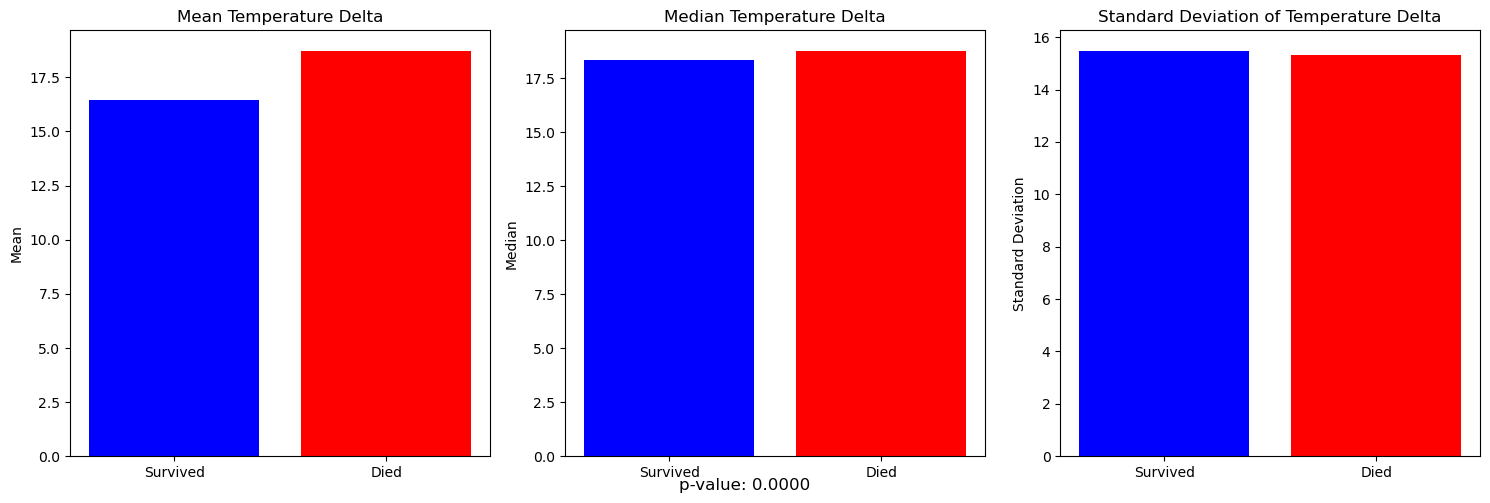

In [49]:
# Data for plotting
categories = ['Survived', 'Died']
means = [s_mean, d_mean]
medians = [s_med, d_med]
std_devs = [s_std, d_std]

# Create histograms
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Mean histogram
ax[0].bar(categories, means, color=['blue', 'red'])
ax[0].set_title('Mean Temperature Delta')
ax[0].set_ylabel('Mean')

# Median histogram
ax[1].bar(categories, medians, color=['blue', 'red'])
ax[1].set_title('Median Temperature Delta')
ax[1].set_ylabel('Median')

# Standard Deviation histogram
ax[2].bar(categories, std_devs, color=['blue', 'red'])
ax[2].set_title('Standard Deviation of Temperature Delta')
ax[2].set_ylabel('Standard Deviation')

# Add footer with p-value
fig.text(0.5, 0.01, f'p-value: {p:.4f}', ha='center', fontsize=12)


# Adjust layout to ensure everything fits
plt.tight_layout()

# Show plot
plt.show()